<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 601.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

# Dataset prepare

In [2]:
# загружаем полный датасет
#raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=25000)
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')
raw_table_data.head(5)

<ipython-input-2-29dd8e705a9f>:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')


,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,13312271,30,40001422,6448421,0,12:31 PM,05.02.2011,Sinus rhythm,Left bundle branch block,NaN,...,60 Hz notch Baseline filter,923,40,144,180,322,614,71,-13,117
1,19289869,20,40001735,6108919,0,2:29 AM,13.06.2011,Sinus rhythm with occasional PACs,Left axis deviation,Left bundle branch block,...,60 Hz notch Baseline filter,800,40,110,184,316,612,63,-34,140
2,11372768,20,40001980,6632385,0,2:01 PM,01.07.2011,Accelerated junctional rhythm,Left bundle branch block,NaN,...,<not specified>,759,460,29999,499,633,930,32767,-32,100
3,14729395,30,40003136,6672155,0,8:52 PM,09.07.2011,Sinus rhythm,Possible anterior infarct - age undetermined,Inferior/lateral ST-T changes may be due to my...,...,60 Hz notch Baseline filter,612,40,182,212,314,580,70,-4,132
4,11933271,40,40003371,6037973,0,2:34 PM,08.04.2013,Sinus rhythm,Possible left atrial abnormality,Tall T waves - consider acute ischemia or hype...,...,60 Hz notch Baseline filter,612,40,128,172,250,506,58,-27,53


In [3]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered['report']

,report
0,Sinus rhythm Left bundle branch block Abnormal...
1,Sinus rhythm with occasional PACs Left axis de...
3,Sinus rhythm Possible anterior infarct - age u...
4,Sinus rhythm Possible left atrial abnormality ...
8,Sinus bradycardia. Normal ECG except for rate
...,...
24993,Sinus bradycardia Possible left anterior fasci...
24995,Sinus bradycardia with 1st degree A-V block Le...
24997,Sinus tachycardia Extensive T wave changes may...
24998,Sinus rhythm Septal T wave changes are nonspec...


In [4]:
#example of diagnosis tokenizing
print(full_df_filtered['report'][1].lower().split())

def get_sentence_embedding(sentence):
    #words = sentence.split()
    words = sentence.lower().split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

#get_sentence_embedding(full_df_filtered['report'][1])

['sinus', 'rhythm', 'with', 'occasional', 'pacs', 'left', 'axis', 'deviation', 'left', 'bundle', 'branch', 'block', 'abnormal', 'ecg']


In [5]:
full_df_filtered['report'].describe()

,report
count,17703
unique,7160
top,Sinus rhythm Normal ECG
freq,3323


In [6]:
# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,13312271,30,40001422,6448421,12:31 PM,05.02.2011,0.025621,923,40,144,180,322,614,71,-13,117,0
1,19289869,20,40001735,6108919,2:29 AM,13.06.2011,0.026653,800,40,110,184,316,612,63,-34,140,0
3,14729395,30,40003136,6672155,8:52 PM,09.07.2011,0.002300,612,40,182,212,314,580,70,-4,132,0
4,11933271,40,40003371,6037973,2:34 PM,08.04.2013,0.011930,612,40,128,172,250,506,58,-27,53,0
8,15726063,20,40006307,6920139,8:01 AM,25.11.2009,-0.028994,1034,40,154,216,308,646,50,59,69,1


In [7]:
# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

#table_data = table_data.head(1000)

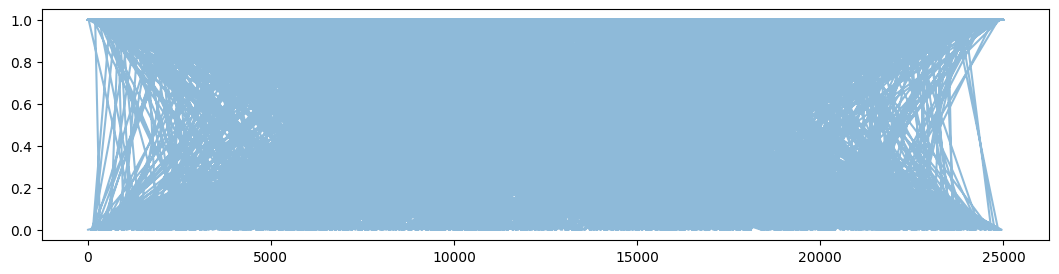

In [8]:
patient_visit_time_array_index = table_data['subject_id'].duplicated()
plt.figure(figsize=(13,3))
plt.plot(patient_visit_time_array_index, alpha = 0.5)

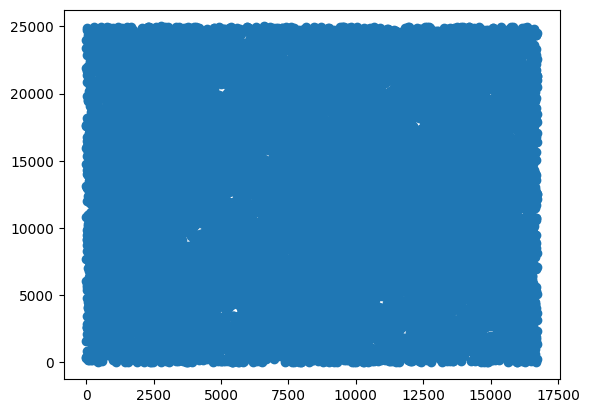

In [9]:

patient_visit_time_array_index = patient_visit_time_array_index[patient_visit_time_array_index[:]==True].index
plt.scatter(range(0,len(patient_visit_time_array_index)), patient_visit_time_array_index)

In [10]:
table_data.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,10002430,46776688,2011-01-08,-0.021591,800,148,208,306,572,66,54,70,1
6030,10002430,42430320,2011-03-10,0.019868,714,140,230,350,636,47,63,33,0
21880,10002430,48702630,2012-03-09,0.033977,1034,164,198,316,674,-52,64,36,0
1601,10002430,40634706,2013-03-29,-0.024212,594,142,180,256,520,39,23,21,1
13125,10002430,45250519,2013-11-26,-0.018268,1071,176,268,410,706,33,-65,76,0


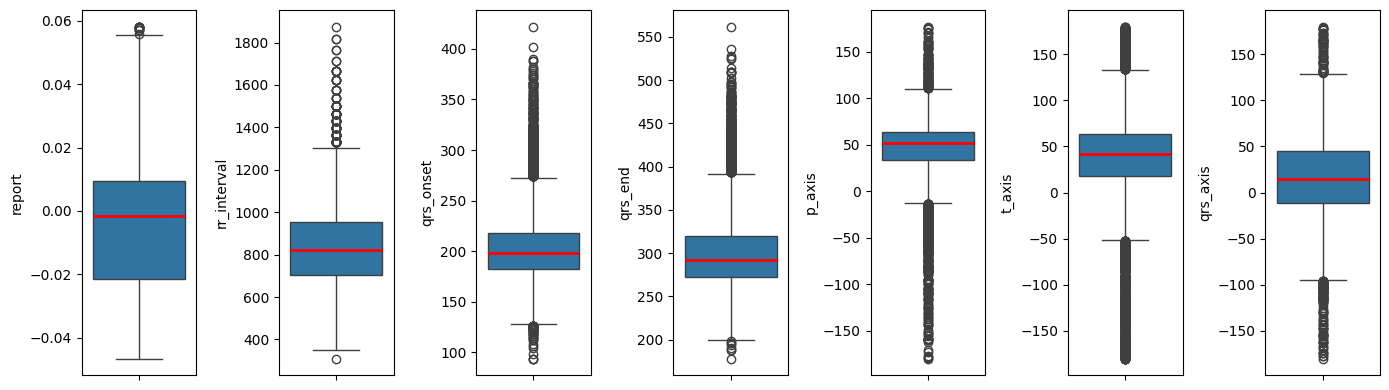

In [11]:
view_table_data = table_data[['report','rr_interval','qrs_onset','qrs_end','p_axis','t_axis','qrs_axis']]

n = view_table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=False)
for i in range(n):
    plt.sca(ax[i])
    col = view_table_data.columns[i]
    sns.boxplot(y = view_table_data.iloc[:,i],data=view_table_data, medianprops={"color": "r", "linewidth": 2})
    fig.tight_layout()

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [12]:
from sklearn.preprocessing import LabelEncoder

# we need to encoder data
encoder = LabelEncoder()
columns_to_encode = list(set(table_data.columns) - {"subject_id","study_id"})
patient_visit_table = table_data
#ecg_table["eeg_date"] = encoder.fit_transform(ecg_table["eeg_date"])
for col in columns_to_encode:
    patient_visit_table[col] = encoder.fit_transform(patient_visit_table[col])

patient_visit_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,1.770300e+04,1.770300e+04,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000
mean,1.499018e+07,4.501793e+07,1359.223239,2452.532791,75.490934,49.235610,50.379540,55.585663,100.403604,180.116477,164.162571,219.799638,0.279388
std,2.830020e+06,2.877138e+06,700.801934,2164.719923,17.444695,9.230378,16.143473,20.827120,30.930900,28.408823,40.845723,49.699325,0.448711
min,1.000243e+07,4.000142e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.253510e+07,4.253763e+07,776.500000,226.000000,66.000000,44.000000,40.000000,42.000000,80.000000,167.000000,138.000000,197.000000,0.000000
50%,1.512751e+07,4.501460e+07,1357.000000,1981.000000,78.000000,50.000000,48.000000,52.000000,99.000000,186.000000,164.000000,221.000000,0.000000
75%,1.740923e+07,4.751539e+07,1953.000000,4241.000000,88.000000,55.000000,58.000000,66.000000,119.000000,198.000000,194.000000,243.000000,1.000000
max,1.998526e+07,4.995937e+07,2803.000000,6723.000000,119.000000,85.000000,143.000000,163.000000,233.000000,294.000000,313.000000,359.000000,1.000000


In [13]:
# define sources and target = edges fot graph

class_values = sorted(patient_visit_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

subject_idx = {name: idx for idx, name in enumerate(sorted(patient_visit_table["subject_id"].unique()))}
patient_visit_table["subject_id"] = patient_visit_table["subject_id"].apply(lambda name: subject_idx[name])


study_idx = {name: idx for idx, name in enumerate(sorted(patient_visit_table["study_id"].unique()))}
patient_visit_table["study_id"] = patient_visit_table["study_id"].apply(lambda name: study_idx[name])

In [14]:
print('Number of class: ',class_values)
print('Total patient records: ', len(patient_visit_table['Healthy_Status']))
patient_visit_table['Healthy_Status'].sum()
patient_visit_table.head()

Number of class:  [0, 1]
Total patient records:  17703


,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,226,76,49,53,59,86,200,203,249,1
6030,0,4228,519,5683,67,45,64,81,118,181,212,212,0
21880,0,15434,884,6489,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,155,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,381,95,63,83,111,153,167,84,255,0


# Data Visualization as a Graph

In [ ]:
#import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

import networkx as nx

## edge end nodes vizualisation

In [ ]:
# Находим дубликаты по 'subject_id'
uniq_patient_visit_table = table_data[table_data.duplicated(subset=['subject_id'], keep=False)]

# Сортируем для удобства (опционально)
uniq_patient_visit_table = uniq_patient_visit_table.sort_values(by='subject_id')
print(len(uniq_patient_visit_table))
uniq_patient_visit_table.head()

17703


,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
15940,0,11250,2668,1261,102,42,101,126,221,145,80,200,0
14763,0,10444,2349,3063,68,33,44,60,67,242,129,311,0
7709,0,5429,2140,2796,76,51,55,58,116,171,222,240,0
17692,0,12484,1842,1376,78,48,50,46,93,211,234,258,1


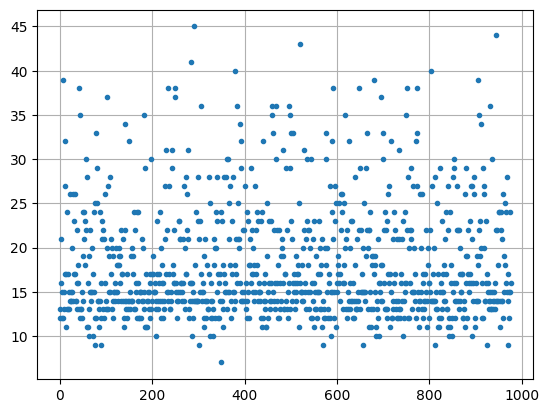

In [ ]:
subject_freq = uniq_patient_visit_table.groupby('subject_id')['study_id'].nunique()
plt.plot(subject_freq,'.')
plt.grid()

In [ ]:
subject_freq

,study_id
subject_id,
0,12
1,13
2,21
3,16
4,12
...,...
972,12
973,15
974,15


In [ ]:
max(pd.unique(uniq_patient_visit_table['subject_id']))

976

In [ ]:
one_patient_df = uniq_patient_visit_table[uniq_patient_visit_table["subject_id"] == 1]
one_patient_df = one_patient_df.sort_values('eeg_date')
one_patient_df

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
11898,1,8394,168,3531,69,44,57,65,102,180,239,103,0
10821,1,7625,773,2427,87,51,50,54,99,210,216,143,0
390,1,279,1348,4615,68,38,35,72,98,191,196,169,0
17631,1,12443,1604,1926,85,47,32,35,84,165,145,296,0
21385,1,15080,1757,3458,84,63,47,50,117,201,206,232,0
5800,1,4058,1815,6765,46,48,38,40,52,213,226,231,0
1680,1,1178,1840,304,103,24,33,32,97,193,187,215,1
16773,1,11834,1944,3503,57,58,57,62,90,165,174,192,0
22872,1,16165,2037,3956,83,60,48,46,113,177,154,222,0
18166,1,12818,2159,3527,52,32,33,30,49,169,152,180,0


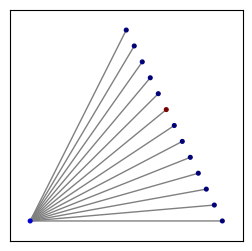

In [ ]:
graph_model = pd.DataFrame(
    {
        "source": one_patient_df['subject_id'],
        "target": one_patient_df['report'],
        "edge_key": one_patient_df['eeg_date'],
        "weight": one_patient_df['report'],
        "status": one_patient_df['Healthy_Status'],
    }
)

color_map = []

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(3, 3))
nx.draw_networkx(
    G,
    pos=nx.planar_layout(G),
    node_size=7,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.jet
)
plt.show()

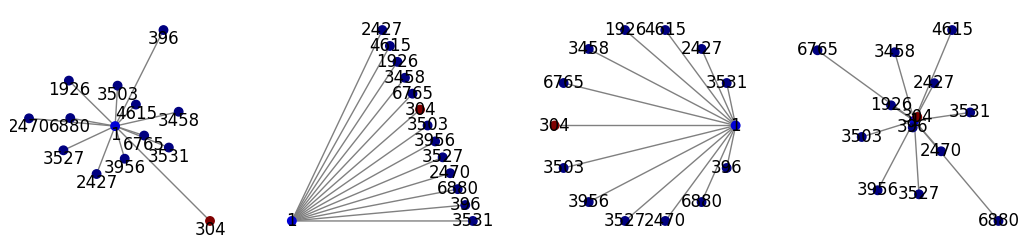

In [ ]:
plt.figure(figsize=(13,3))
# plt.subplot() will create "sub-plots" in one canvas
# Now we are telling matplotlib to give us a 2x2 subplot canvas
plt.subplot(141)  # first subplot
nx.draw_spring(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet, verticalalignment='top', node_size=37, edge_color='grey')
plt.subplot(142) # second subplot
nx.draw_planar(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(143) # third subplot
nx.draw_circular(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(144) # last subplot
nx.draw_kamada_kawai(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')

In [ ]:
#duplicated_rows=duplicated_rows.head(len(duplicated_rows)//2)
#duplicated_rows = duplicated_rows.sample(3000)
graph_model = pd.DataFrame(
    {
        "source": uniq_patient_visit_table['subject_id'],
        "target": uniq_patient_visit_table['study_id'],
        "edge_key": uniq_patient_visit_table['eeg_date'],
        "weight": uniq_patient_visit_table['report'],
        "status": uniq_patient_visit_table['Healthy_Status'],
    }
)
print(len(graph_model))

17703


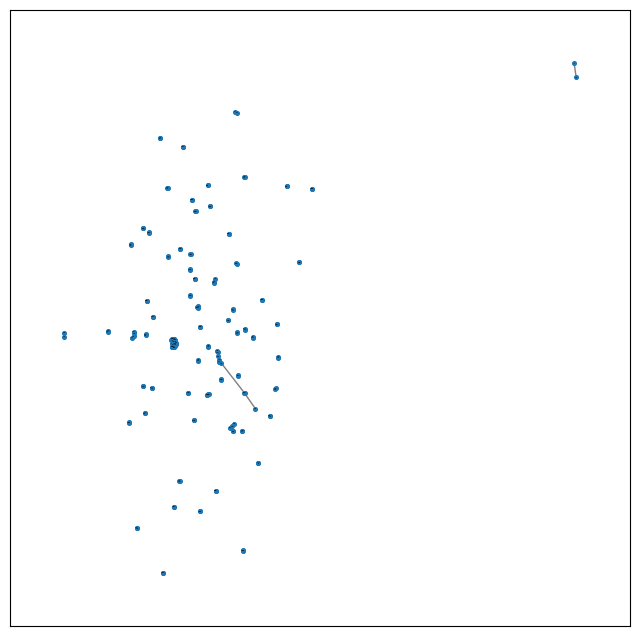

In [ ]:
G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

color_map = graph_model['status'].to_numpy()
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos=nx.spring_layout(G),
                 node_size=7, font_size = 0,edge_color ='grey',
                 #node_color=color_map,
                 )

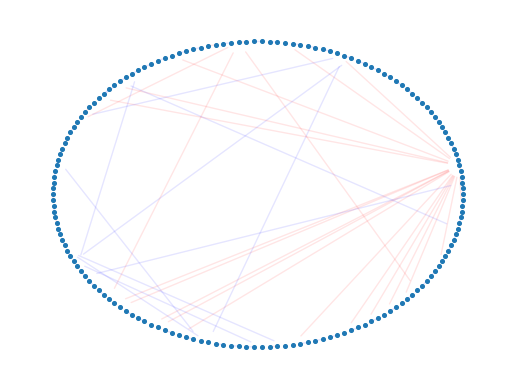

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, alpha=0.1, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.1, edge_color="b", style="solid"
)


ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
#plt.tight_layout()
plt.show()


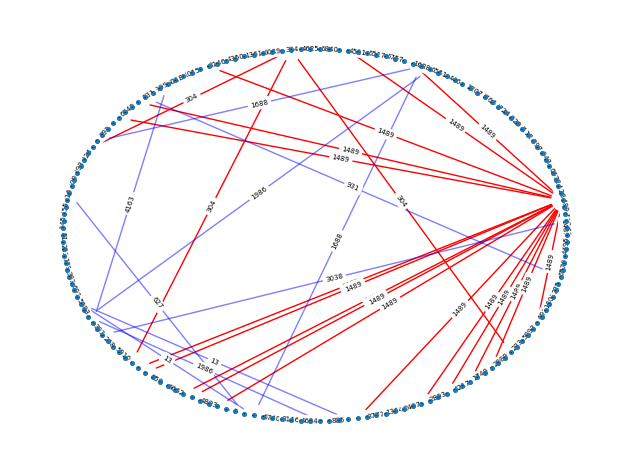

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


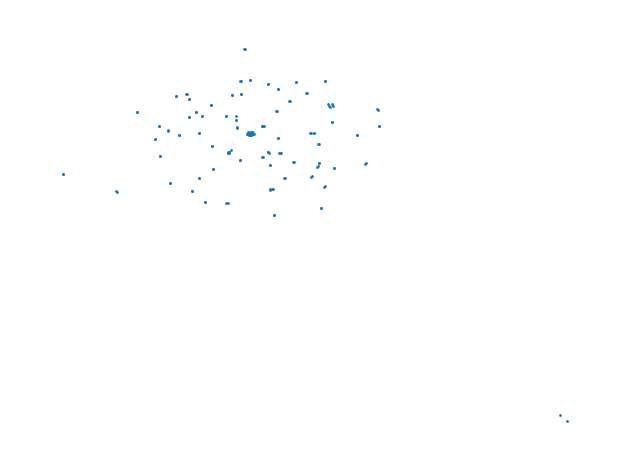

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.spring_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=0.5, alpha=0.1, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=0.5, alpha=0.1, edge_color="b", style="dashed")

# node labels
#nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

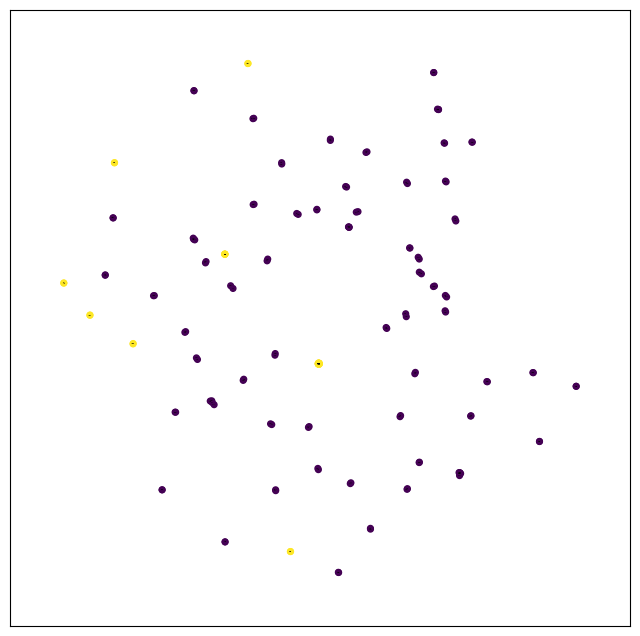

In [ ]:
# If you want to color nodes based on some aggregation of their connected edges' status
color_map = []
for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,
    pos=nx.kamada_kawai_layout(G),
    node_size=17,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.viridis
)
plt.show()

# Model: GNN vs MLP (Graph Neural Network / Feed forward network)

In [ ]:
import random
patient_visit_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6734,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5426,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,421,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,507,95,63,83,111,153,167,84,255,0


## example of dataframe to graph transform

In [ ]:
#duplicated_rows=duplicated_rows.head(len(duplicated_rows)//2)
#duplicated_rows = duplicated_rows.sample(3000)
graph_model = pd.DataFrame(
    {
        "source": patient_visit_table['subject_id'],
        "target": patient_visit_table['study_id'],
        "edge_key": patient_visit_table['eeg_date'],
        "weight": patient_visit_table['report'],
        "status": patient_visit_table['Healthy_Status'],
    }
)
print(len(graph_model))

In [ ]:
#class_values = sorted(ecg_table["Healthy_Status"].unique())
class_values = sorted(graph_model["status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

#feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
feature_names = list(set(graph_model.columns) - {"status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
#y_train = train_data["Healthy_Status"]
#y_test = test_data["Healthy_Status"]
y_train = train_data["status"]
y_test = test_data["status"]

[0, 1]

In [ ]:
train_data, test_data = [], []

#for _, group_data in ecg_table.groupby("subject_id"):
for _, group_data in graph_model.groupby("source"):
#for _, group_data in graph_model.groupby("source"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2357, 5)
Test data shape: (643, 5)


## Vanila MLP NN

In [ ]:
train_data, test_data = [], []

random.seed(13)
for _, group_data in patient_visit_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14165, 13)
Test data shape: (3538, 13)


In [ ]:
feature_names = list(set(patient_visit_table.columns) - {"subject_id", "study_id", "eeg_date", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │      1,540 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │         66 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,078 (43.27 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 594 (2.32 KB)

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train (loss)", "test (loss)"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train (acc)", "test (val_acc)"], loc="lower right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.grid()

    #plt.grid()
    plt.show()

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - acc: 0.6531 - loss: 0.9411 - val_acc: 0.7181 - val_loss: 0.8177
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7392 - loss: 0.4797 - val_acc: 0.7181 - val_loss: 0.6012
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.7536 - loss: 0.4439 - val_acc: 0.7981 - val_loss: 0.3593
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.7575 - loss: 0.4337 - val_acc: 0.8438 - val_loss: 0.3323
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7684 - loss: 0.4180 - val_acc: 0.8631 - val_loss: 0.3146
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7767 - loss: 0.4129 - val_acc: 0.8504 - val_loss: 0.3145
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7784 - loss: 0.4125 - val_acc: 0.8456 - val_loss: 0.3166
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7905 - loss: 0.3996 - val_acc: 0.8508 - val_loss: 0.3116
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.781

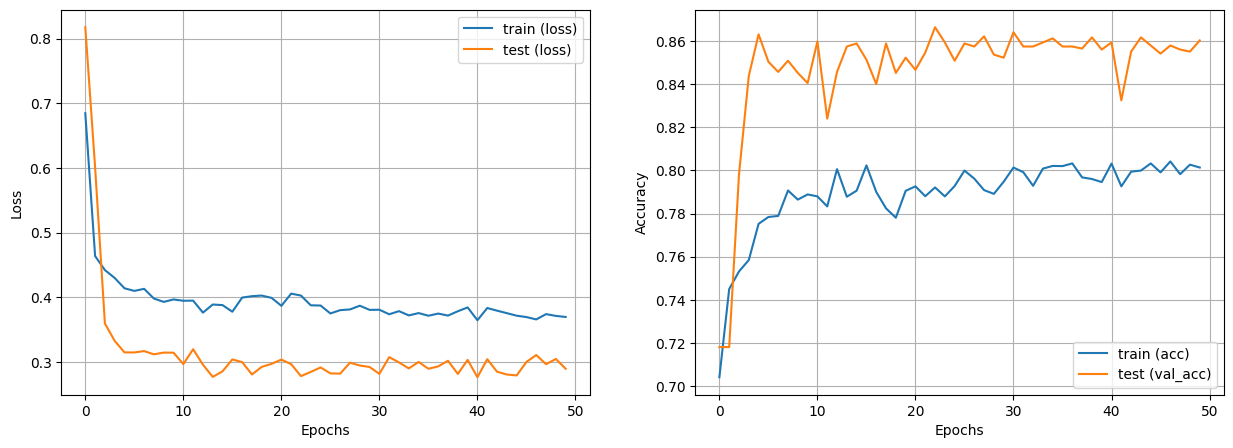

In [ ]:
display_learning_curves(history)

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 86.74%


In [ ]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Instance 1:
- 0: 99.84%
- 1: 0.16%
Instance 2:
- 0: 99.84%
- 1: 0.16%


## Graph Neural Network

In [ ]:
patient_visit_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6734,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5426,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,421,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,507,95,63,83,111,153,167,84,255,0


In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = patient_visit_table[["subject_id", "study_id"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])*patient_visit_table['report']/max(patient_visit_table['report'])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    patient_visit_table.sort_values("subject_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_patient_visits = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 17703)
Nodes shape: (17703, 10)


In [ ]:
graph_patient_visits

(<tf.Tensor: shape=(17703, 10), dtype=float32, numpy=
 array([[  59.,   49.,  203., ..., 1489.,  200.,   86.],
        [ 126.,   42.,   80., ..., 1261.,  145.,  221.],
        [  60.,   33.,  129., ..., 3063.,  242.,   67.],
        ...,
        [  75.,   58.,   68., ..., 2545.,  180.,  124.],
        [  70.,   48.,  129., ..., 1201.,  196.,  108.],
        [  67.,   47.,  146., ...,  304.,  190.,  141.]], dtype=float32)>,
 array([[    0,     0,     0, ...,   976,   976,   976],
        [11911,  4228, 15434, ...,  2584,   202,   970]]),
 <tf.Tensor: shape=(17703,), dtype=float32, numpy=
 array([0.20804806, 0.94089705, 0.7581389 , ..., 0.8810954 , 0.35559592,
        0.0424759 ], dtype=float32)>)

In [ ]:
class_values = sorted(patient_visit_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [ ]:
train_data, test_data = [], []

random.seed(13)
for _, group_data in patient_visit_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14044, 13)
Test data shape: (3659, 13)


In [ ]:
feature_names = list(set(patient_visit_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [ ]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
        x = layers.GRU(
            units=units,
            activation="tanh",
            recurrent_activation="sigmoid",
            return_sequences=True,
            dropout=dropout_rate,
            return_state=False,
            recurrent_dropout=dropout_rate,
        )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


"""
### Implement a graph neural network node classifier

The GNN classification model follows the [Design Space for Graph Neural Networks](https://arxiv.org/abs/2011.08843) approach,
as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections,  to the node representation
to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generate  the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours.
However, adding many graph convolutional layer can cause oversmoothing, where the model
produces similar embeddings for all the nodes.

Note that the `graph_info` passed to the constructor of the Keras model, and used as a *property*
of the Keras model object, rather than input data for training or prediction.
The model will accept a **batch** of `node_indices`, which are used to lookup the
node features and neighbours from the `graph_info`.
"""


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_patient_visits,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_train = train_data.report.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - acc: 0.6243 - loss: 23.6401 - val_acc: 0.7162 - val_loss: 0.5988
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - acc: 0.8778 - loss: 0.3600 - val_acc: 0.8918 - val_loss: 0.3160
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - acc: 0.8986 - loss: 0.2777 - val_acc: 0.8942 - val_loss: 0.2863
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - acc: 0.8981 - loss: 0.2665 - val_acc: 0.8908 - val_loss: 0.2534
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - acc: 0.9100 - loss: 0.2345 - val_acc: 0.9445 - val_loss: 0.1723
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - acc: 0.9549 - loss: 0.1353 - val_acc: 0.9464 - val_loss: 0.1713
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - acc: 0.9553 - loss: 0.1293 - val_acc: 0.9535 - val_loss: 0.1732
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - acc: 0.9609 - loss: 0.1447 - val_acc: 0.9639 - val_loss: 0.1570
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/

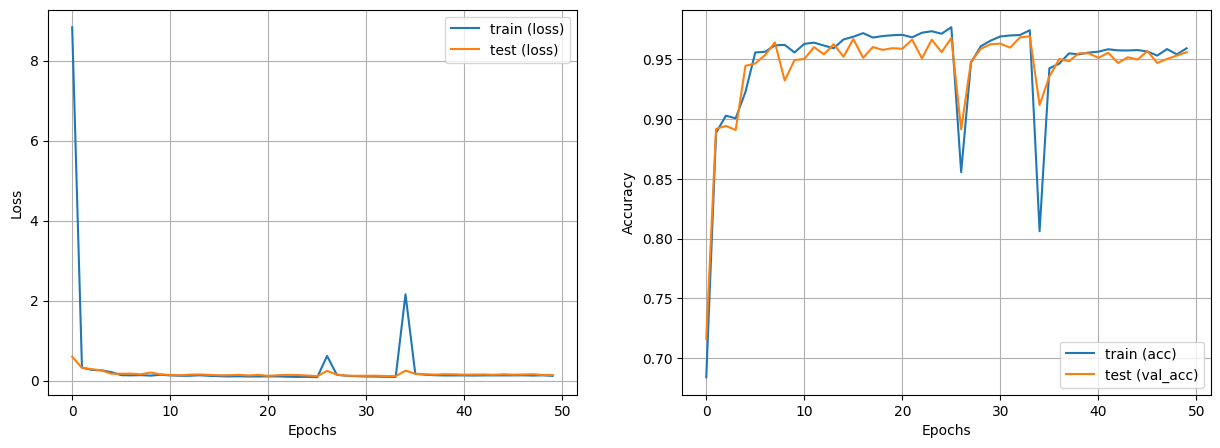

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data.report.to_numpy()
#x_test = test_data.source.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.27%


In [ ]:
#new_instances = generate_random_instances(num_classes)
token_probability = x_train.mean(axis=0)
instances = []
for _ in range(3):
        probabilities = np.random.uniform(size = num_features)
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)
new_instances = instances

In [ ]:
node_features.shape

TensorShape([17703, 10])

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]


## Create a node features array of shape [num_nodes, num_features].
##node_features = tf.cast(
##    ecg_table.sort_values("subject_id")[feature_names].to_numpy(),
##    dtype=tf.dtypes.float32)

new_node_features = np.concatenate([node_features, new_instances])

# Second we add the M edges (it's a kind of next patient visits) from each new node to a set
# of existing nodes in a particular subject

new_node_indices = [i + num_nodes for i in range(3)]

new_patient_visits = []
for subject_idx, group in patient_visit_table.groupby("Healthy_Status"):
    subject_patient = list(group.subject_id)
    # Select random x nodes specific patient.
    selected_node_indices1 = np.random.choice(subject_patient, 3)
    # Select random y nodes from any subject as a patient (where y < x).
    selected_node_indices2 = np.random.choice(list(patient_visit_table.subject_id), 2)
    # Merge the selected node indices.
    selected_node_indices = np.concatenate(
        [selected_node_indices1, selected_node_indices2], axis=0
    )
    # Create edges between a patient visits idx and the selected subject.
    patient_indx = new_node_indices[subject_idx]
    for old_patient_visit_idx in selected_node_indices:
        new_patient_visits.append([patient_indx, old_patient_visit_idx])


new_patient_visits = np.array(new_patient_visits).T
new_edges = np.concatenate([edges, new_patient_visits], axis=1)

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (17703, 10)
Original edges shape: (2, 17703)
New node_features shape: (17706, 10)
New edges shape: (2, 17713)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
Instance 1:
- 0: 92.6%
- 1: 7.4%
Instance 2:
- 0: 92.53%
- 1: 7.47%
Instance 3:
- 0: 99.43%
- 1: 0.57%


In [ ]:
view_ecg_table = ecg_table.sample(n=100)

graph_model = pd.DataFrame(
    {
        "source": view_ecg_table['subject_id'],
        "target": view_ecg_table['report'],
        "edge_key": view_ecg_table['eeg_date'],
        "weight": view_ecg_table['report'],
        "status": view_ecg_table['Healthy_Status'],
    }
)

graph_model.head()

,source,target,edge_key,weight,status
8463,578,5638,704,5638,0
1456,479,4710,305,4710,0
1697,882,1489,2302,1489,1
7716,903,6128,2319,6128,0
22721,717,6672,611,6672,0


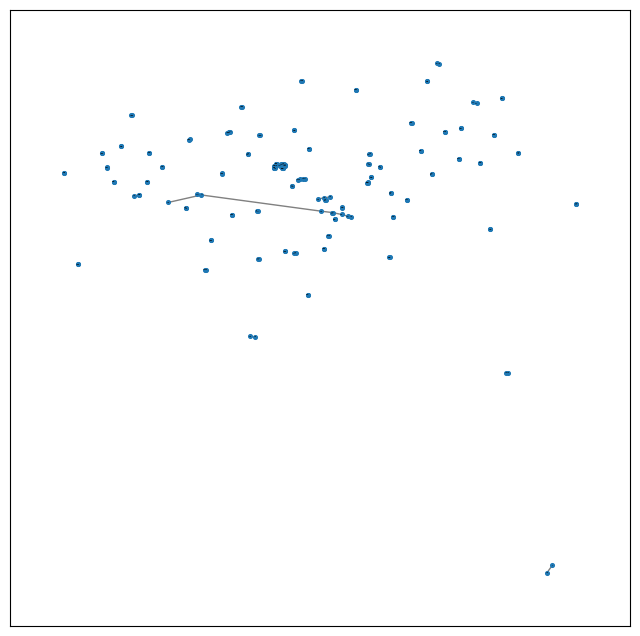

In [ ]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))

nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 1,edge_color ='grey')



# Torch framework graph GCN model

In [15]:
!pip install -q torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [16]:
from torch_geometric.utils import from_networkx, to_networkx

In [17]:
import torch
import tensorflow as tf
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import remove_isolated_nodes, degree
from collections import Counter
from sklearn.manifold import TSNE

In [18]:
patient_visit_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,226,76,49,53,59,86,200,203,249,1
6030,0,4228,519,5683,67,45,64,81,118,181,212,212,0
21880,0,15434,884,6489,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,155,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,381,95,63,83,111,153,167,84,255,0


In [19]:
feature_names = list(set(patient_visit_table.columns) - {"subject_id", "study_id", "eeg_date", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

In [20]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = patient_visit_table[["subject_id", "study_id"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])*patient_visit_table['report']/max(patient_visit_table['report'])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    patient_visit_table.sort_values("subject_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_patient_visits = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 17703)
Nodes shape: (17703, 9)


In [21]:
class_values = sorted(patient_visit_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [22]:
graph_patient_visits

(<tf.Tensor: shape=(17703, 9), dtype=float32, numpy=
 array([[203., 249.,  86., ...,  59.,  49., 200.],
        [ 80., 200., 221., ..., 126.,  42., 145.],
        [129., 311.,  67., ...,  60.,  33., 242.],
        ...,
        [ 68., 269., 124., ...,  75.,  58., 180.],
        [129., 206., 108., ...,  70.,  48., 196.],
        [146., 217., 141., ...,  67.,  47., 190.]], dtype=float32)>,
 array([[    0,     0,     0, ...,   976,   976,   976],
        [11911,  4228, 15434, ...,  2584,   202,   970]]),
 <tf.Tensor: shape=(17703,), dtype=float32, numpy=
 array([0.03361595, 0.8453072 , 0.9651941 , ..., 0.78134763, 0.50751156,
        0.00743716], dtype=float32)>)

In [23]:
# Function to convert edge list to adjacency matrix
def convert_to_adjacency_matrix(edge_list, num_vertices):
  # Initialize the adjacency matrix with all zeros
  adj_mat = [[0 for _ in range(num_vertices)] for _ in range(num_vertices)]

  # Iterate through all the edges
  for edge in edge_list:
    # Get the source and destination nodes
    source = edge[0]
    destination = edge[1]

    # Mark the edge between source and destination in adjacency matrix
    adj_mat[source][destination] = 1

    #  Mark the edge between destination and source in adjacency matrix
    # (since the graph is bidirectional)
    adj_mat[destination][source] = 1

  return adj_mat

#edge_list = [[0, 1], [0, 2], [1, 2], [1, 3], [2, 4], [2, 5], [2,1]]
# There are 6 vertices/nodes in total
# The first vertex/node is labelled as 0
# And the last vertex/node is labelled as 5
num_vertices = edges.shape[1]
adj_mat = convert_to_adjacency_matrix(edges, num_vertices)

In [24]:
G = nx.from_numpy_array(np.array(adj_mat))

data = from_networkx(G)

In [25]:
data

Data(edge_index=[2, 3], weight=[3], num_nodes=17703)

In [26]:
#data.x = node_features



data.x = torch.tensor(patient_visit_table.sort_values("subject_id")[feature_names].to_numpy()).float()

target = patient_visit_table[["Healthy_Status"]].to_numpy().T
#data.y = target
data.y = torch.tensor(target[0])

data.weight = edge_weights

data.num_node_features = data.x.shape[1]
data.num_classes = len(class_values)

In [27]:
def create_random_masks(total_nodes, train_percent, test_percent, val_percent):
    """
    Создает случайно распределенные маски для train, test и validation наборов

    Параметры:
    total_nodes (int): Общее количество узлов
    train_percent (float): Процент узлов для обучения (0-1)
    test_percent (float): Процент узлов для тестирования (0-1)
    val_percent (float): Процент узлов для валидации (0-1)

    Возвращает:
    tuple: (train_mask, test_mask, val_mask) - три булевых массива со случайным распределением
    """
    # Проверка корректности процентов
    assert np.isclose(train_percent + test_percent + val_percent, 1.0), \
        "Сумма процентов должна быть равна 1"

    # Создаем массив для хранения всех меток
    labels = np.empty(total_nodes, dtype=np.int8)

    # Вычисляем количество узлов для каждой категории
    train_count = int(train_percent * total_nodes)
    test_count = int(test_percent * total_nodes)
    val_count = total_nodes - train_count - test_count

    # Заполняем массив метками (0 - train, 1 - test, 2 - val)
    labels[:train_count] = 0
    labels[train_count:train_count+test_count] = 1
    labels[train_count+test_count:] = 2

    # Случайно перемешиваем метки
    np.random.shuffle(labels)

    # Создаем булевы маски
    train_mask = (labels == 0)
    test_mask = (labels == 1)
    val_mask = (labels == 2)

    return train_mask, test_mask, val_mask

# Пример использования:
total_nodes = data.x.shape[0]  # Меньшее количество для наглядности
train_percent = 0.7  # 60%
test_percent = 0.2    # 20%
val_percent = 0.1     # 20%

train_mask, test_mask, val_mask = create_random_masks(total_nodes, train_percent, test_percent, val_percent)


data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)
data.val_mask = torch.tensor(val_mask, dtype=torch.bool)

In [28]:
data.y

tensor([1, 0, 0,  ..., 0, 0, 1])

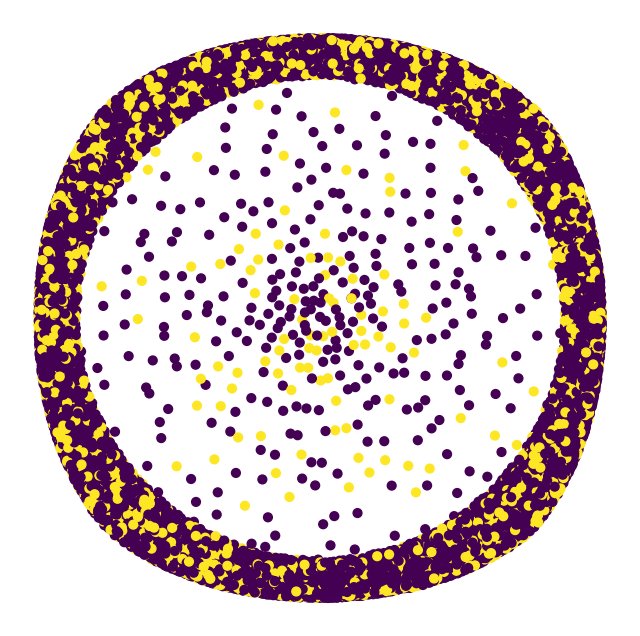

In [ ]:
Graph_graph_patient_visits = to_networkx(data, to_undirected=True)
plt.figure(figsize=(8,8))
plt.axis('off')
nx.draw_networkx(Graph_graph_patient_visits,
                pos=nx.spring_layout(Graph_graph_patient_visits),
                with_labels=False,
                node_size=40,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

In [55]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_h)
        self.gcn3 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=4):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def graph_model_accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def graph_model_train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 300
    acc_ts = []

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = graph_model_accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = graph_model_accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        acc_ts = np.append(acc_ts, val_acc)

    return model, acc_ts

def graph_model_test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = graph_model_accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [56]:
data.y

tensor([1, 0, 0,  ..., 0, 0, 1])

In [57]:
%%time

gcn = GCN(data.x.shape[1], 16, data.num_classes)
print(gcn)

model, acc_ts = graph_model_train(gcn, data)

acc = graph_model_test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(9, 16)
  (gcn2): GCNConv(16, 16)
  (gcn3): GCNConv(16, 2)
)
Epoch   0 | Train Loss: 835.487 | Train Acc:   6.47% | Val Loss: 841.51 | Val Acc: 7.23%
Epoch  10 | Train Loss: 248.217 | Train Acc:  41.37% | Val Loss: 278.88 | Val Acc: 40.37%
Epoch  20 | Train Loss: 120.720 | Train Acc:  59.34% | Val Loss: 108.82 | Val Acc: 59.91%
Epoch  30 | Train Loss: 49.779 | Train Acc:  58.36% | Val Loss: 49.95 | Val Acc: 57.99%
Epoch  40 | Train Loss: 15.942 | Train Acc:  59.25% | Val Loss: 16.60 | Val Acc: 57.71%
Epoch  50 | Train Loss: 5.141 | Train Acc:  53.04% | Val Loss: 5.06 | Val Acc: 53.30%
Epoch  60 | Train Loss: 2.089 | Train Acc:  67.87% | Val Loss: 2.04 | Val Acc: 69.00%
Epoch  70 | Train Loss: 1.397 | Train Acc:  68.68% | Val Loss: 1.36 | Val Acc: 69.45%
Epoch  80 | Train Loss: 1.139 | Train Acc:  68.19% | Val Loss: 1.15 | Val Acc: 69.23%
Epoch  90 | Train Loss: 1.009 | Train Acc:  70.34% | Val Loss: 1.02 | Val Acc: 70.69%
Epoch 100 | Train Loss: 1.434 | Train Acc:

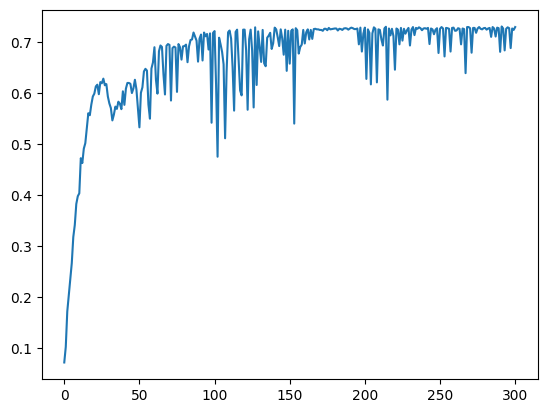

In [59]:
plt.plot(acc_ts)

In [50]:
%%time

#gat = GAT(dataset.num_features, 8, dataset.num_classes)
gat = GAT(data.x.size()[1],16, data.num_classes)
print(gat)
graph_model_train(gat, data)
acc = graph_model_test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(9, 16, heads=4)
  (gat2): GATv2Conv(64, 2, heads=1)
)
Epoch   0 | Train Loss: 256.502 | Train Acc:  56.18% | Val Loss: 253.76 | Val Acc: 53.92%
Epoch  10 | Train Loss: 134.318 | Train Acc:  59.97% | Val Loss: 120.90 | Val Acc: 61.77%
Epoch  20 | Train Loss: 56.386 | Train Acc:  57.15% | Val Loss: 55.95 | Val Acc: 57.59%
Epoch  30 | Train Loss: 19.859 | Train Acc:  62.75% | Val Loss: 20.95 | Val Acc: 62.68%
Epoch  40 | Train Loss: 5.479 | Train Acc:  62.73% | Val Loss: 5.49 | Val Acc: 62.85%
Epoch  50 | Train Loss: 1.847 | Train Acc:  62.86% | Val Loss: 1.84 | Val Acc: 63.02%
Epoch  60 | Train Loss: 1.140 | Train Acc:  56.16% | Val Loss: 1.09 | Val Acc: 56.63%
Epoch  70 | Train Loss: 1.633 | Train Acc:  70.43% | Val Loss: 1.66 | Val Acc: 70.13%
Epoch  80 | Train Loss: 0.916 | Train Acc:  69.15% | Val Loss: 0.91 | Val Acc: 70.81%
Epoch  90 | Train Loss: 0.716 | Train Acc:  69.63% | Val Loss: 0.73 | Val Acc: 69.45%
Epoch 100 | Train Loss: 0.675 | Train Acc:  68.73

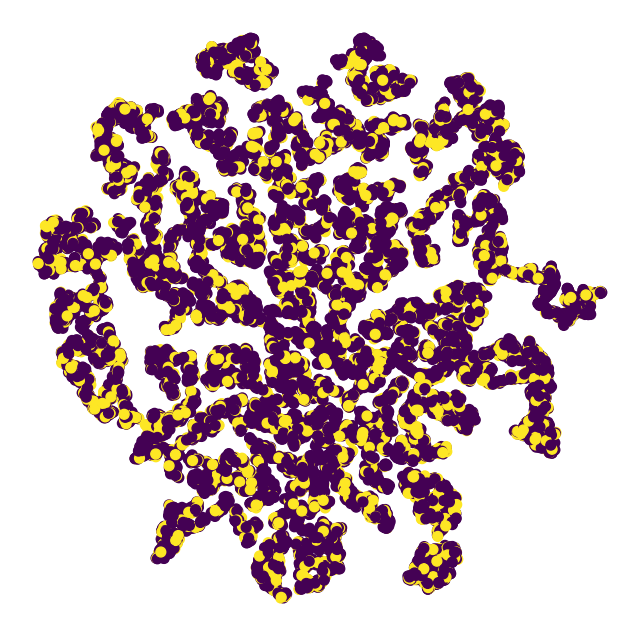

In [ ]:
untrained_gat = GAT(data.x.shape[1],16, data.num_classes)


# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)


tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

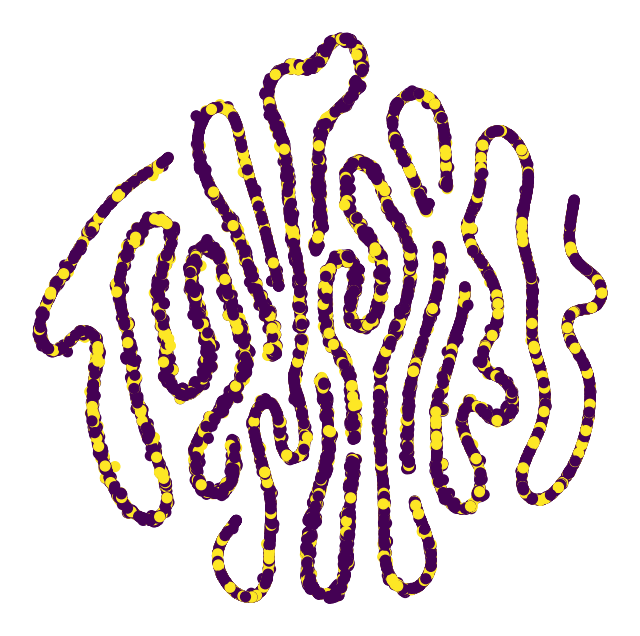

In [33]:
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Old ECG graph visualisation

In [ ]:
edge_index = torch.from_numpy(graph_model[["source", "target"]].to_numpy())
#node_features = torch.from_numpy(np.array(graph_model["weight"].tolist()))
node_features = torch.from_numpy(np.array(graph_model["weight"].to_numpy()))

#label = torch.from_numpy(np.array(graph_model["status"].tolist()))
label = torch.from_numpy(graph_model[["status"]].to_numpy())

edge_attr = torch.from_numpy(graph_model[["weight"]].to_numpy())

#data = Data(x=x, edge_index=edge_index.T)
data = Data(x=node_features,
            #edge_index=edge_index,
            edge_index=edge_index.t().contiguous(),
            edge_attr=edge_attr,
            y=label, #you can add more arguments as you like
                    )
data
#data.num_features

NameError: name 'graph_model' is not defined

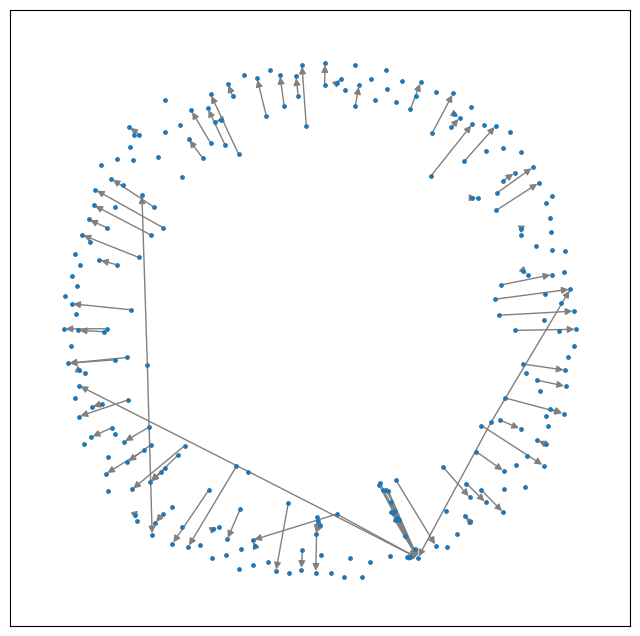

In [ ]:
graph = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
# Draw the graph

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)#, k=2)
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=False,
    edge_color='grey',
    node_size=6,
)
plt.show()

In [ ]:
G.edges(data=True)

MultiEdgeDataView([(699, 5357, {'weight': 5357, 'status': 0}), (910, 5799, {'weight': 5799, 'status': 0}), (128, 5499, {'weight': 5499, 'status': 0}), (436, 6320, {'weight': 6320, 'status': 0}), (883, 382, {'weight': 382, 'status': 0}), (928, 1441, {'weight': 1441, 'status': 0}), (849, 1821, {'weight': 1821, 'status': 1}), (1821, 953, {'weight': 1821, 'status': 1}), (1821, 313, {'weight': 1821, 'status': 1}), (1821, 597, {'weight': 1821, 'status': 1}), (1821, 825, {'weight': 1821, 'status': 1}), (1821, 279, {'weight': 1821, 'status': 1}), (1821, 580, {'weight': 1821, 'status': 1}), (1821, 609, {'weight': 1821, 'status': 1}), (1821, 945, {'weight': 1821, 'status': 1}), (1821, 164, {'weight': 1821, 'status': 1}), (1821, 761, {'weight': 1821, 'status': 1}), (1821, 611, {'weight': 1821, 'status': 1}), (1821, 384, {'weight': 1821, 'status': 1}), (1821, 475, {'weight': 1821, 'status': 1}), (1821, 36, {'weight': 1821, 'status': 1}), (1821, 764, {'weight': 1821, 'status': 1}), (1821, 631, {'we